# Code to generate figure 3 in the publication
Analysis of sensitive enzymes and reactions in the model simulations of protein overexpression

In [1]:
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec

import pandas as pd
import numpy as np
import os
import sys
from optlang.symbolics import Zero

from PAModelpy.configuration import Config
from PAModelpy.EnzymeSectors import ActiveEnzymeSector, UnusedEnzymeSector, TransEnzymeSector, CustomSector
from PAModelpy.Enzyme import Enzyme

sys.path.append('../Scripts/')
from pam_generation import set_up_ecoli_pam

DATA_DIR = os.path.join(os.path.split(os.getcwd())[0], 'Data')
eGFP_MW = 2.8*1e4 #g/mol
eGFP_RANGE = np.arange(0,0.15,0.01)
GLC_CONC = 9.81 #mmol_glc/gcdw/h
eGFP_BEINICK_DATA_PATH = os.path.join(DATA_DIR, 'eGFP_expression_Bienick2014.xls')
eGFP_SEQ_PATH = os.path.join(DATA_DIR, 'eGFP_protein_sequence.txt')
BIOMASS_RXNID = Config.BIOMASS_REACTION

Loading PAModelpy modules version 0.0.3.3


In [2]:
BIOMASS_RXNID = 'BIOMASS_Ec_iML1515_core_75p37M'

## sensitivities of protein overexpression in the PAM of E.coli

### 1. Usefull functions

#### 1.1 Sensitivity analysis

In [3]:
def calculate_sensitivities(pamodel):
    #initialize objects for storing information
    results_df = pd.DataFrame(columns = ['eGFP', 'mu', 'mu_normalized'])
    Ccsc = [] #capacity sensitivity coefficients
    Cesc = [] #variable sensitivity coefficients
    x_axis_esc = []
    x_axis_csc = []
    y_axis = []
    fluxes = []
    
    # #set glucose uptake rate
    # pamodel.change_reaction_bounds(rxn_id = 'EX_glc__D_e', 
    #                                         lower_bound = -100, upper_bound = 0)
    
    #set glucose uptake rate
    pamodel.change_reaction_bounds(rxn_id = 'EX_glc__D_e', 
                                            lower_bound = -GLC_CONC, upper_bound = -GLC_CONC)
    
    
    for conc in eGFP_RANGE:
        print('Running simulations with the following eGFP concentration: ', conc, 'mmol/g_cdw/h')
        with pamodel:
            #change eGFP concentration
            pamodel.constraints['eGFP_min'].ub = -conc*1e3
            sol_pam = pamodel.optimize()
            #check if simulation is optimal
            if pamodel.solver.status == 'optimal': 
                y_axis += [conc]
                
                # save data
                fluxes.append(sol_pam.fluxes) # flux distributions
    
                # calculate normalized growth rate
                mu = pamodel.reactions.get_by_id(BIOMASS_RXNID).flux
                if conc == 0:
                    mu_normalized = 1
                    mu_wt = mu
                else:
                    mu_normalized = mu/mu_wt
                results_df.loc[len(results_df)] = [conc,mu, mu_normalized]
    
                #save sensitivities
                Ccsc_new = list()
                capacity_coeff = pamodel.capacity_sensitivity_coefficients
                for csc in ['flux_ub', 'flux_lb', 'enzyme_max','enzyme_min','proteome', 'sector']:
                    if csc == 'EC_min_f':
                        Ccsc_new += [-coef for coef in capacity_coeff[capacity_coeff['constraint'] == csc].coefficient.to_list()]
                    else:
                        Ccsc_new += capacity_coeff[capacity_coeff['constraint'] == csc].coefficient.to_list()
                
                Ccsc += [Ccsc_new]
                
                enzyme_coeff = pamodel.enzyme_sensitivity_coefficients
                Cesc += [enzyme_coeff.coefficient.to_list()]
                
                print('Sum of capacity sensitivity coefficients: \t \t \t \t \t \t \t', round(sum(Ccsc_new),6))
                print('Sum of variable sensitivity coefficients: \t \t \t \t \t \t \t', round(sum(Cesc[-1]),6), '\n')

    return {'Ccsc':Ccsc, 'Cesc':Cesc, 'y_axis':y_axis, 'fluxes':fluxes, 'capacity coefficients':capacity_coeff, 
            'enzyme coefficients':enzyme_coeff, 'results': results_df}
            

In [4]:
def find_nonzero_sensitivities(Cv, x_axis):
    indices = []
    for row in Cv:
        for index, coeff in enumerate(row):
            if abs(coeff)>0.09 and index not in indices:
                indices.append(index)
    
    coeff_nonzero = []
    for row in Cv:
        coeff_nonzero.append([coeff for i, coeff in enumerate(row) if i in indices])
    x_coeff_nonzero = [coeff for i, coeff in enumerate(x_axis) if i in indices]

    return coeff_nonzero, x_coeff_nonzero

In [5]:
def find_top5_sensitivities(Cv, x_axis, yaxis):
    #top 5 enzymes per simulation
    Cv_df = pd.DataFrame(Cv, columns = x_axis, index =yaxis)
    largest = list()
    for i, row in Cv_df.iterrows():
        top5 = abs(row).nlargest()        
        if top5.iloc[0]:
            largest += [index for index, value in top5.items() if abs(value)>0.05]
            print([index for index, value in top5.items() if abs(value)>0.05])
    
    #remove duplicates
    largest_list = list(set(largest))

    #extract non duplicate top5 enzymes
    top5_df = Cv_df[largest_list].T.drop_duplicates().sort_index()
    largest_list = top5_df.index.values

    top5_matrix = [list(row) for i, row in top5_df.iterrows()]
    return top5_matrix, largest_list


#### 1.2 Plotting

In [6]:
def parse_x_axis_heatmap(capacity_coeff, enzyme_coeff):
    x_axis_csc = []
    
    for csc in ['flux_ub', 'flux_lb', 'enzyme_max','enzyme_min','proteome', 'sector']:
        if csc == 'flux_ub' or csc == 'flux_lb':
            x_axis_csc += [coef+'_'+ csc for coef in capacity_coeff[capacity_coeff['constraint'] == csc].rxn_id.to_list()]
        else:
            x_axis_csc += [coef+'_'+ csc for coef in capacity_coeff[
            capacity_coeff['constraint'] == csc].enzyme_id.to_list()]
    
    x_axis_esc = enzyme_coeff.enzyme_id.to_list()
    return x_axis_csc, x_axis_esc

In [7]:
def make_heatmap_subfigure(results, csc_matrix, esc_matrix, x_csc, x_esc, yaxis, fig, grdspc, ylabels = True, cbar =True, title = None,
                           fontsize = 16, vmin = -1.5, vmax = 1.5, annotate = None, phenotype_data = None,cmap = plt.cm.get_cmap('viridis')):
    # fig = plt.figure()

    if cbar:
        gs = gridspec.GridSpecFromSubplotSpec(2, 2, width_ratios=[len(yaxis), 1], 
                                            height_ratios=[len(x_csc), len(x_esc)], hspace =0, subplot_spec=grdspc)
    else:
        gs = gridspec.GridSpecFromSubplotSpec(2, 1, width_ratios=[len(yaxis)], 
                                            height_ratios=[len(x_csc), len(x_esc)], hspace =0, subplot_spec=grdspc)
    
    esc_ax = fig.add_subplot(gs[1,0]) #ESC heatmap
    csc_ax = fig.add_subplot(gs[0,0],sharex = esc_ax) #CSC heatmap
    if cbar:
        cbar_ax = fig.add_subplot(gs[0:,1]) #colorbar

    #add annotation for subfigure (A or B)
    if annotate is not None:
        csc_ax.annotate(annotate, xy=(2, 1), xycoords='data',
            xytext=(-0.05,1.1), textcoords='axes fraction',
            va='top', ha='left', fontsize = fontsize+5, weight = 'bold')

    #CAC heatmap
    im_csc = csc_ax.imshow(csc_matrix, aspect="auto", vmin = vmin, vmax =vmax,cmap = cmap)
    if title is not None: csc_ax.set_title(title, fontsize = fontsize*1.5)
    csc_ax.set_yticks(np.arange(len(x_csc)), labels=x_csc, fontsize =fontsize)
    csc_ax.xaxis.set_visible(False)
    if ylabels:
        csc_ax.set_ylabel('CSC', fontsize = fontsize*1.5)

    #Make line between CSC and ESC data more clear
    axis = 'bottom'
    csc_ax.spines[axis].set_linewidth(10)
    csc_ax.spines[axis].set_color("black")
    csc_ax.spines[axis].set_zorder(0)
    
    #ESC heatmap
    im_esc = esc_ax.imshow(esc_matrix, aspect="auto", vmin = vmin, vmax =vmax,cmap = cmap)
    esc_ax.set_yticks(np.arange(len(x_esc)), labels=x_esc, fontsize =fontsize)
    esc_ax.set_xticks(np.arange(len(yaxis)),labels = yaxis, fontsize =fontsize, rotation=45, ha='right')
    if ylabels:
        esc_ax.set_ylabel('ESC', fontsize = fontsize*1.5)
        
    #colorbar
    if cbar:
        cbar_ax.xaxis.set_visible(False)
        # cbar_ax.yaxis.set_visible(False)
        make_scaled_colorbar(ax=cbar_ax, vmin=vmin, vmax=vmax, fig = fig, fontsize = fontsize,cmap = cmap)

    return fig

In [8]:
def make_scaled_colorbar(ax, fig, cmap = 'viridis', vmin =-1, vmax = 1, fontsize = 16, cbarlabel = 'Sensitivity Coefficient'):
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm = norm)
    sm.set_array([])
    
    cbar = fig.colorbar(sm, ax =ax, cax=ax, shrink = 1, fraction = 1)
    #setting the fontsize of the colourbar
    cbar.set_label(cbarlabel,fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.ax.yaxis.get_offset_text().set(size=fontsize)

In [9]:
#adjust labels for better readibility
def adjust_heatmap_labels(labels):
    new_labels = labels.copy()

    for i, label in enumerate(labels):
        if 'EX_glc__D_e' in label or label[:-3] == 'EX_glc__D_e':
            if label[-1] == 'B': new_labels[i] = 'EX_glc_'+label[-2:]
            else: new_labels[i] = 'EX_glc_lb'
        if label == 'TotalProteinConstraint_proteome':
            new_labels[i] = 'Protein pool'
        if label == 'eGFP_enzyme_min':
            new_labels[i] = 'eGFP_min'
        if label[0].isdigit(): #all enzyme ids start with a digit
            if label == '2.7.3.9':
                new_labels[i] = 'Glucose\ntransport'
            else:
                rxn_ids = pamodel.get_reactions_with_enzyme_id(label)
                rxn_name = pamodel.reactions.get_by_id(rxn_ids[-1]).name.split('(')[0]
                new_labels[i] = '\n'.join([part for part in rxn_name.split(' ')])
    return new_labels

## 1.3 Determining aminoacid content of eGFP

In [10]:
def check_freq(x, total):
    return {c: x.count(c)/total for c in set(x)}

In [11]:
#aminoacid lookup table
aa_lookup ={'V':'VAL', 'I':'ILE', 'L':'LEU', 'E':'GLU', 'Q':'GLN', \
'D':'ASP', 'N':'ASN', 'H':'HIS', 'W':'TRP', 'F':'PHE', 'Y':'TYR',    \
'R':'ARG', 'K':'LYS', 'S':'SER', 'T':'THR', 'M':'MET', 'A':'ALA',    \
'G':'GLY', 'P':'PRO', 'C':'CYS'}

In [12]:
#read amino acid sequence
with open(eGFP_SEQ_PATH) as f:
    lines = f.readlines()
#need to remove document start ('\ufeff') and end ('\n') to only yield the amino acid sequence
aa_seq = lines[0].strip().replace('\ufeff', '')

print(aa_seq)

MRKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFGYGVQCFARYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYKLEHHHHHH


In [13]:
#determine amino acid composition
aa_freq = check_freq(aa_seq, len(aa_seq))

#match to model identifiers
aa_biggid_freq = dict()
for aa, freq in aa_freq.items():
    threeletter = aa_lookup[aa].lower()
    if threeletter != 'gly':
        bigg_id = f'{threeletter}__L_c'
    else: 
        bigg_id = f'{threeletter}_c'
    aa_biggid_freq[bigg_id] = freq
    
aa_biggid_freq

{'ser__L_c': 0.032520325203252036,
 'pro__L_c': 0.04065040650406504,
 'gln__L_c': 0.032520325203252036,
 'cys__L_c': 0.008130081300813009,
 'thr__L_c': 0.06097560975609756,
 'his__L_c': 0.06504065040650407,
 'leu__L_c': 0.08130081300813008,
 'lys__L_c': 0.08130081300813008,
 'gly_c': 0.09349593495934959,
 'phe__L_c': 0.052845528455284556,
 'ile__L_c': 0.04878048780487805,
 'arg__L_c': 0.028455284552845527,
 'asp__L_c': 0.07317073170731707,
 'met__L_c': 0.024390243902439025,
 'val__L_c': 0.06910569105691057,
 'trp__L_c': 0.0040650406504065045,
 'ala__L_c': 0.036585365853658534,
 'tyr__L_c': 0.044715447154471545,
 'glu__L_c': 0.06910569105691057,
 'asn__L_c': 0.052845528455284556}

In [14]:
def add_aminoacid_sequence(model, seq, protein):
    """
    model: COBRA model
    seq: dict with {aminoacid_id: freq} key, value pairs
    protein: enzyme variable
    """
    for aa, freq in seq.items():
        model.constraints[aa].set_linear_coefficients({
        protein.forward_variable: -freq/protein.molmass,
        protein.reverse_variable: -freq/protein.molmass
    })    
    return model

### 2 Run PAM simulations with default protein content
#### 2.1 Build the model and add the eGFP protein

In [15]:
pamodel = set_up_ecoli_pam()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-07
Read LP format model from file /tmp/tmppinmn5ow.lp
Reading time = 0.02 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Setting up the proteome allocation model iML1515

Add total condition-dependent protein constraint
	Total protein concentration: 0.258 g/gDW

Add active protein sector



/home/samiralvdb/.local/lib/python3.10/site-packages/PAModelpy/PAModel.py:222: UserWarning: Molar mass for E332 is invalid: 0.0
  warnings.warn(f'Molar mass for {enz.id} is invalid: {molmass}')


Add the following protein sector: TranslationalProteinSector

Add the following protein sector: 

Done with setting up the proteome allocation model iML1515



In [16]:
#add eGFP enzyme and aminoacid consumption
eGFP_enzyme = Enzyme('eGFP', {}, molmass = 1e6) #molmass of 1e6 to get a direct relation between enzyme concentration and total protein content
pamodel.add_enzymes([eGFP_enzyme])
pamodel = add_aminoacid_sequence(pamodel, aa_biggid_freq, pamodel.enzyme_variables.get_by_id('eGFP'))

#turn off Pyruvate Formate Lyase (PFL) reaction (inhibited by oxygen)
pamodel.change_reaction_bounds('PFL',0,0)

#### 2.3 Run simulations for different eGFP concentrations

In [17]:
results_pam = calculate_sensitivities(pamodel)
x_axis_csc_pam,x_axis_esc_pam = parse_x_axis_heatmap(results_pam['capacity coefficients'], results_pam['enzyme coefficients'])

Running simulations with the following eGFP concentration:  0.0 mmol/g_cdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 	 1.0
Sum of variable sensitivity coefficients: 	 	 	 	 	 	 	 0.735457 

Running simulations with the following eGFP concentration:  0.01 mmol/g_cdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 	 1.0
Sum of variable sensitivity coefficients: 	 	 	 	 	 	 	 0.725774 

Running simulations with the following eGFP concentration:  0.02 mmol/g_cdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 	 1.0
Sum of variable sensitivity coefficients: 	 	 	 	 	 	 	 0.715353 

Running simulations with the following eGFP concentration:  0.03 mmol/g_cdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 	 1.0
Sum of variable sensitivity coefficients: 	 	 	 	 	 	 	 0.704107 

Running simulations with the following eGFP concentration:  0.04 mmol/g_cdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 	 1.0
Sum of variable sensitivity coefficients: 	

In [18]:
#get nonzero sensitivities
csc_nonzero_pam, x_csc_nonzero_pam = find_nonzero_sensitivities(results_pam['Ccsc'], x_axis = x_axis_csc_pam)
esc_nonzero_pam, x_esc_nonzero_pam = find_nonzero_sensitivities(results_pam['Cesc'], x_axis = x_axis_esc_pam)

In [19]:
csc_nonzero_pam_t = np.transpose(np.array(csc_nonzero_pam))
esc_nonzero_pam_t = np.transpose(np.array(esc_nonzero_pam))

In [20]:
#get top5 nonzero sensitivities
csc_top5_pam, x_csc_top5_pam = find_top5_sensitivities(results_pam['Ccsc'], x_axis = x_axis_csc_pam, yaxis = eGFP_RANGE)
esc_top5_pam, x_esc_top5_pam = find_top5_sensitivities(results_pam['Cesc'], x_axis = x_axis_esc_pam, yaxis = eGFP_RANGE)

['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome', 'eGFP_enzyme_min']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome', 'eGFP_enzyme_min', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalPro

### 3. Run PAM simulations with more efficient ATP synthase
ATP synthase is the enzyme contributing the most to the enzyme burden

#### 3.1 Build PAModel

In [21]:
#get old kcat value to change
old_kcat_atp = pamodel.enzymes.get_by_id('3.6.3.14').get_kcat_values('ATPS4rpp')['f']
old_kcat_atp

79.0

In [22]:
pamodel_atp = set_up_ecoli_pam()

Read LP format model from file /tmp/tmp0m8ntqgo.lp
Reading time = 0.01 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Setting up the proteome allocation model iML1515

Add total condition-dependent protein constraint
	Total protein concentration: 0.258 g/gDW

Add active protein sector



/home/samiralvdb/.local/lib/python3.10/site-packages/PAModelpy/PAModel.py:222: UserWarning: Molar mass for E332 is invalid: 0.0
  warnings.warn(f'Molar mass for {enz.id} is invalid: {molmass}')


Add the following protein sector: TranslationalProteinSector

Add the following protein sector: 

Done with setting up the proteome allocation model iML1515



In [23]:
#make atp synthase enzyme twice as efficient
new_kcat_atp = old_kcat_atp*2
active_enzyme = pamodel.sectors.get_by_id('ActiveEnzymeSector')
for rxn, kcat in {'ATPS4rpp':{'f': new_kcat_atp}}.items():
    print(rxn)
    print(kcat)
    print(active_enzyme.rxn2protein[rxn])

pamodel_atp.change_kcat_value(enzyme_id = '3.6.3.14', kcats = {'ATPS4rpp':{'f': new_kcat_atp}})

#add eGFP protein
pamodel_atp.add_enzymes([eGFP_enzyme])
pamodel_atp = add_aminoacid_sequence(pamodel_atp, aa_biggid_freq, pamodel_atp.enzyme_variables.get_by_id('eGFP'))

#turn off Pyruvate Formate Lyase (PFL) reaction (inhibited by oxygen)
pamodel_atp.change_reaction_bounds('PFL',0,0)

ATPS4rpp
{'f': 158.0}
{'3.6.3.14': {'f': 79.0, 'b': 285.0, 'molmass': 234022.89499999996}}


#### 3.2 Run simulations for different eGFP concentrations

In [24]:
results_atp = calculate_sensitivities(pamodel_atp)

Running simulations with the following eGFP concentration:  0.0 mmol/g_cdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 	 1.000506
Sum of variable sensitivity coefficients: 	 	 	 	 	 	 	 0.780457 

Running simulations with the following eGFP concentration:  0.01 mmol/g_cdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 	 1.000526
Sum of variable sensitivity coefficients: 	 	 	 	 	 	 	 0.771913 

Running simulations with the following eGFP concentration:  0.02 mmol/g_cdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 	 1.000547
Sum of variable sensitivity coefficients: 	 	 	 	 	 	 	 0.762675 

Running simulations with the following eGFP concentration:  0.03 mmol/g_cdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 	 1.00057
Sum of variable sensitivity coefficients: 	 	 	 	 	 	 	 0.752655 

Running simulations with the following eGFP concentration:  0.04 mmol/g_cdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 	 1.000598
Sum of variable sen

In [25]:
#parse results for nice plotting
x_axis_csc_atp,x_axis_esc_atp = parse_x_axis_heatmap(results_atp['capacity coefficients'], results_atp['enzyme coefficients'])

#find top 5 sensitivities
csc_top5_atp, x_csc_top5_atp = find_top5_sensitivities(results_atp['Ccsc'], x_axis = x_axis_csc_atp, yaxis = eGFP_RANGE)
esc_top5_atp, x_esc_top5_atp = find_top5_sensitivities(results_atp['Cesc'], x_axis = x_axis_esc_atp, yaxis = eGFP_RANGE)

['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome', 'eGFP_enzyme_min']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome', 'eGFP_enzyme_min']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_m

### 3. Run PAM simulations with total protein content of 0.31 g/g_cdw
#### 3.1 Build PAModel

In [26]:
pamodel_inc = set_up_ecoli_pam(total_protein =0.31)
#add eGFP protein
pamodel_inc.add_enzymes([eGFP_enzyme])
pamodel_inc = add_aminoacid_sequence(pamodel_inc, aa_biggid_freq, pamodel_inc.enzyme_variables.get_by_id('eGFP'))

#turn off Pyruvate Formate Lyase (PFL) reaction (inhibited by oxygen)
pamodel_inc.change_reaction_bounds('PFL',0,0)

Read LP format model from file /tmp/tmp3z__gvj1.lp
Reading time = 0.01 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Setting up the proteome allocation model iML1515

Add total condition-dependent protein constraint
	Total protein concentration: 0.31 g/gDW

Add active protein sector



/home/samiralvdb/.local/lib/python3.10/site-packages/PAModelpy/PAModel.py:222: UserWarning: Molar mass for E332 is invalid: 0.0
  warnings.warn(f'Molar mass for {enz.id} is invalid: {molmass}')


Add the following protein sector: TranslationalProteinSector

Add the following protein sector: 

Done with setting up the proteome allocation model iML1515



#### 3.2 Run simulations for different eGFP concentrations

In [27]:
results_inc = calculate_sensitivities(pamodel_inc)

Running simulations with the following eGFP concentration:  0.0 mmol/g_cdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 	 1.0
Sum of variable sensitivity coefficients: 	 	 	 	 	 	 	 0.113115 

Running simulations with the following eGFP concentration:  0.01 mmol/g_cdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 	 1.0
Sum of variable sensitivity coefficients: 	 	 	 	 	 	 	 0.673889 

Running simulations with the following eGFP concentration:  0.02 mmol/g_cdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 	 1.0
Sum of variable sensitivity coefficients: 	 	 	 	 	 	 	 0.753316 

Running simulations with the following eGFP concentration:  0.03 mmol/g_cdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 	 1.0
Sum of variable sensitivity coefficients: 	 	 	 	 	 	 	 0.745336 

Running simulations with the following eGFP concentration:  0.04 mmol/g_cdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 	 1.0
Sum of variable sensitivity coefficients: 	

In [28]:
#parse x-axis
x_axis_csc_inc,x_axis_esc_inc = parse_x_axis_heatmap(results_inc['capacity coefficients'], results_inc['enzyme coefficients'])
#get nonzero sensitivities
csc_nonzero_inc, x_csc_nonzero_inc = find_nonzero_sensitivities(results_inc['Ccsc'], x_axis = x_axis_csc_inc)
esc_nonzero_inc, x_esc_nonzero_inc = find_nonzero_sensitivities(results_inc['Cesc'], x_axis = x_axis_esc_inc)
csc_nonzero_inc_t = np.transpose(np.array(csc_nonzero_inc))
esc_nonzero_inc_t = np.transpose(np.array(esc_nonzero_inc))

In [29]:
#get top5 nonzero sensitivities
csc_top5_inc, x_csc_top5_inc = find_top5_sensitivities(results_inc['Ccsc'], x_axis = x_axis_csc_inc, yaxis = eGFP_RANGE)
esc_top5_inc, x_esc_top5_inc = find_top5_sensitivities(results_inc['Cesc'], x_axis = x_axis_esc_inc, yaxis = eGFP_RANGE)

['EX_glc__D_e_flux_lb']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome', 'eGFP_enzyme_min']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome', 'eGFP_enzyme_min']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome', 'eGFP_enzyme_min']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome', 'eGFP_enzyme_min']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome', 'eGFP_enzyme_min']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome', 'eGFP_enzyme_min']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome', 'eGFP_enzyme_min', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteo

### 4 Create plot

#### 4.1 Load phenotypic data

In [30]:
# load phenotype data from excel file
pt_data = pd.read_excel(os.path.join(DATA_DIR, 'Ecoli_phenotypes','Ecoli_phenotypes_py_rev.xls'), sheet_name='Yields', index_col=None)
pt_data['EX_glc__D_e'] = -pt_data['EX_glc__D_e']

/tmp/ipykernel_10455/2944335199.py:46: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig('Figure3_sensitivities_protein-overproduction.png', dpi =200,bbox_inches='tight')
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


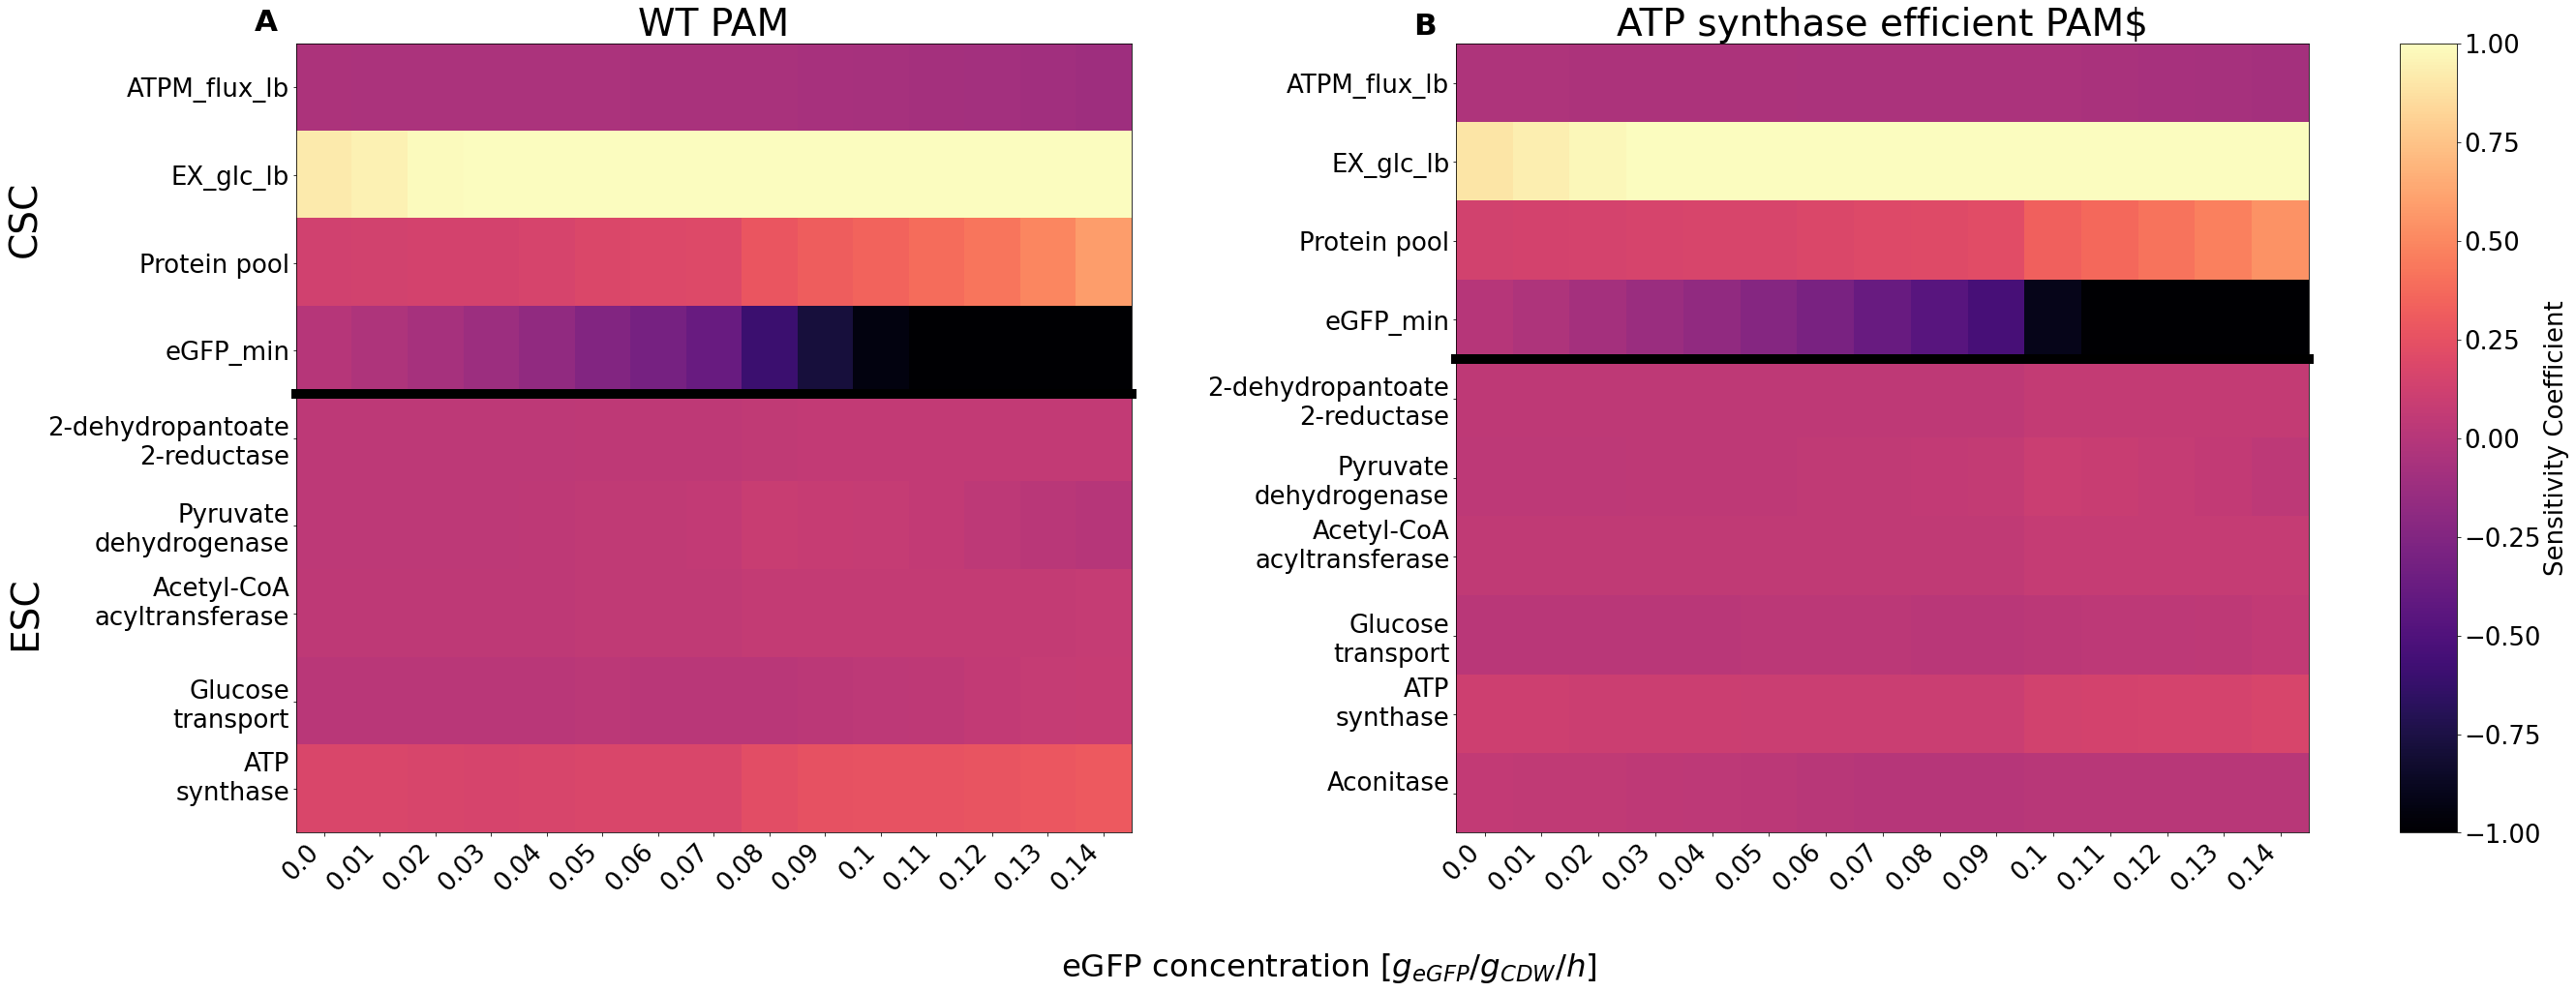

In [31]:
#create 1 big plot
fontsize = 26
vmin =-1
vmax=1
width = 40
height = 15
cmap = 'magma'

# gridspec inside gridspec
fig = plt.figure(layout = 'constrained')

gs0 = gridspec.GridSpec(1, 14, figure=fig, wspace = 25)
gs_pam = gs0[:6]
gs_inc = gs0[7:]

#adjust labels for better readibility
x_csc_label_pam = adjust_heatmap_labels(x_csc_top5_pam)
x_esc_label_pam = adjust_heatmap_labels(x_esc_top5_pam)


fig_pam = make_heatmap_subfigure(results = results_pam, csc_matrix=csc_top5_pam, esc_matrix =esc_top5_pam,cbar =False,title = 'WT PAM',
                                   x_csc=x_csc_label_pam, x_esc=x_esc_label_pam, yaxis = eGFP_RANGE, fig = fig, grdspc = gs_pam,
                                   annotate = 'A', vmin = vmin, vmax=vmax, fontsize = fontsize, cmap = cmap)

# adjust labels for better readibility
x_csc_label_atp = adjust_heatmap_labels(x_csc_top5_atp)
x_esc_label_atp = adjust_heatmap_labels(x_esc_top5_atp)


fig_inc = make_heatmap_subfigure(results = results_atp, csc_matrix=csc_top5_atp, esc_matrix =esc_top5_atp, ylabels = False,
                                 title = 'ATP synthase efficient PAM$', x_csc=x_csc_label_atp, x_esc=x_esc_label_atp, yaxis = eGFP_RANGE, 
                                 fig = fig, grdspc=gs_inc, annotate = 'B',  vmin = vmin, vmax=vmax, fontsize = fontsize, cmap = cmap)

#set common x axis title
ax_xlabel = fig.add_subplot(gs0[0, :2])
ax_xlabel.set_xticks([])
ax_xlabel.set_yticks([])
ax_xlabel.set_frame_on(False)
ax_xlabel.set_xlabel('eGFP concentration [$g_{eGFP}/g_{CDW}/h$]', fontsize = fontsize*1.25)
ax_xlabel.xaxis.set_label_coords(6, -.15)

fig.set_figwidth(width)
fig.set_figheight(height)
fig.align_labels()

fig.savefig('Figure3_sensitivities_protein-overproduction.png', dpi =200,bbox_inches='tight')

## 4.2 plot normalized growth rate as function of eGFP concentration
Similar to what has been done by [Alter et al. (2021)](https://journals.asm.org/doi/10.1128/mSystems.00625-20)

In [32]:
#get eGFP data from Bienick et al. (2014)
egfp_exp = pd.read_excel(eGFP_BEINICK_DATA_PATH, sheet_name='eGFPvsMu')
mu_wt = 0.75

egfp_exp['mu_normalized'] = egfp_exp['Growth rate'].apply(lambda x: x/mu_wt)
egfp_exp['mu_error_normalized'] = egfp_exp['Growth rate error'].apply(lambda x: x/mu_wt)

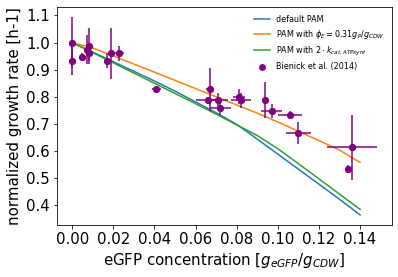

In [33]:
fig, ax = plt.subplots()
ax.plot(results_pam['results']['eGFP'], results_pam['results']['mu_normalized'], label = 'default PAM')
ax.plot(results_inc['results']['eGFP'], results_inc['results']['mu_normalized'], label = 'PAM with $\phi_{E} = 0.31 g_{P}/g_{CDW}$')
ax.plot(results_atp['results']['eGFP'], results_atp['results']['mu_normalized'], label = 'PAM with $2 \cdot k_{cat,ATPsynt}$')

ax.scatter(egfp_exp['eGFP concentration'], egfp_exp['mu_normalized'],
                   color='purple', marker='o', s=30, linewidths=1.3,
                   facecolors=None, zorder=0,
                   label='Bienick et al. (2014)')
ax.errorbar(egfp_exp['eGFP concentration'], egfp_exp['mu_normalized'], 
            yerr= egfp_exp['mu_error_normalized'], xerr = egfp_exp['eGFP concentration error'],
           fmt="o", color='purple')


# Set the tick labels font
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
ax.set_xlabel('eGFP concentration [$g_{eGFP}/g_{CDW}$]', fontsize = 15)
ax.set_ylabel('normalized growth rate [h-1]', fontsize =15)

ax.legend(fontsize=8, edgecolor='white', facecolor='white', framealpha=1)


plt.show()

fig.savefig('SuppFigure3_eGFP-normalized_mu.png', dpi =200,bbox_inches='tight')

## 4.3 plot predicted exchange rates
Similar to what has been done by [Alter et al. (2021)](https://journals.asm.org/doi/10.1128/mSystems.00625-20)

/tmp/ipykernel_10455/1469718941.py:48: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


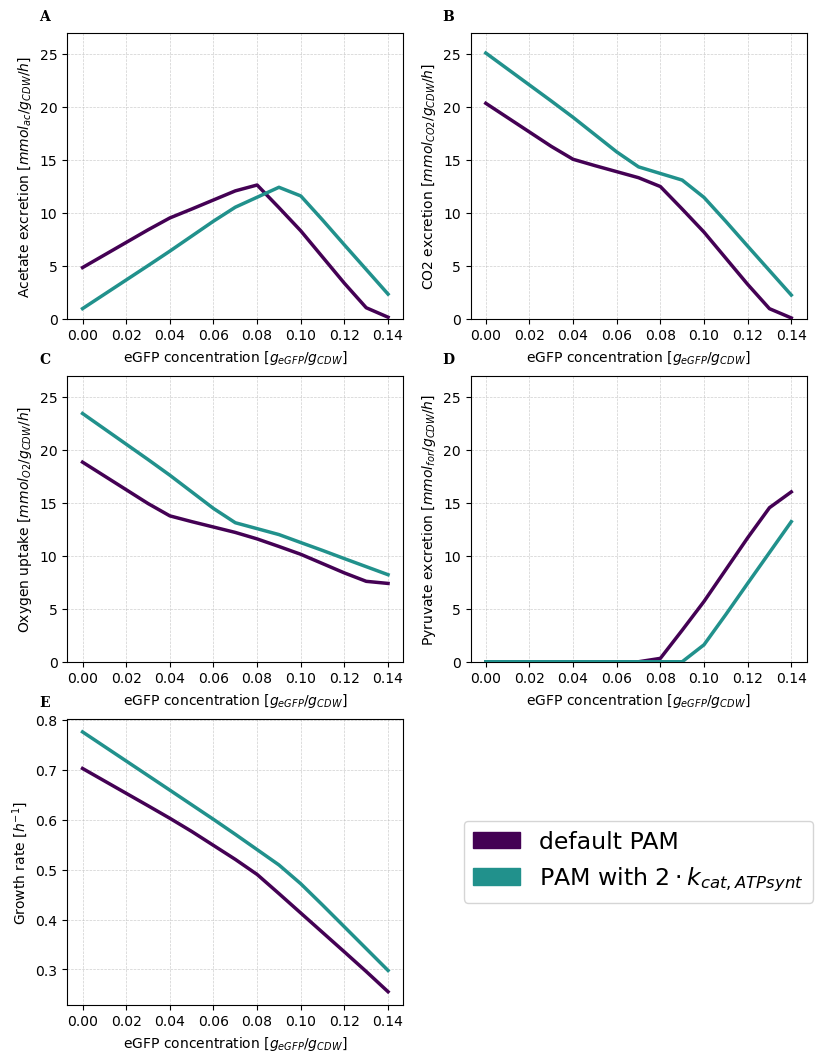

In [34]:
fontsize = 10

#plot flux changes with eGFP concentration
import matplotlib.transforms as mtransforms
fig, axs = plt.subplot_mosaic([['A', 'B'], ['C', 'D'], ['E', '']],
                              layout='constrained', dpi =100)
for label, ax in axs.items():
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', va='bottom', fontfamily='serif', weight = 'bold')

rxn_id = ['EX_ac_e', 'EX_co2_e', 'EX_o2_e', 'EX_pyr_e', BIOMASS_RXNID]
ylabels = ['Acetate excretion [$mmol_{ac}/g_{CDW}/h$]', 'CO2 excretion [$mmol_{CO2}/g_{CDW}/h$]', 
           'Oxygen uptake [$mmol_{O2}/g_{CDW}/h]$', 'Pyruvate excretion [$mmol_{for}/g_{CDW}/h$]','Growth rate [$h^{-1}$]']
# fig, axs = plt.subplots(2,2, dpi=100)
for i,r in enumerate(rxn_id):
    ax_label = ['A', 'B', 'C', 'D', 'E'][i]
    ax = axs[ax_label]
    if r != BIOMASS_RXNID:
        ax.set_ylim([0,27])
    # plot simulation
    line_pam = ax.plot(eGFP_RANGE, [abs(f[r]) for f in results_pam['fluxes']], linewidth=2.5,
            zorder=5, color ='#440154')
    
    # plot simulation with increases protein capacity
    line_atp = ax.plot(eGFP_RANGE, [abs(f[r]) for f in results_atp['fluxes']],linewidth=2.5,
            zorder=5, color = '#21918c')
   
    
    # options
    ax.set_xlabel('eGFP concentration [$g_{eGFP}/g_{CDW}$]', fontsize = fontsize)
    ax.set_ylabel(ylabels[i], fontsize = fontsize)
    # set grid
    ax.grid(True, axis='both', linestyle='--', linewidth=0.5, alpha=0.6   )
    ax.set_axisbelow(True)
    # show legend
    # ax.legend(fontsize=8, edgecolor='white', facecolor='white', framealpha=1)
    
axs[''].axis('off')
# Manually create legend handles (patches)
blue_patch = matplotlib.patches.Patch(color='#440154', label='default PAM')
orange_patch = matplotlib.patches.Patch(color='#21918c', label='PAM with $2 \cdot k_{cat,ATPsynt}$')

# Add legend to bottom-right ax
axs[''].legend(handles=[blue_patch, orange_patch], loc='center', fontsize = fontsize+7)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.2)
fig.set_figheight(13)
fig.set_figwidth(10)
fig.savefig('SuppFigure3_simulated-physiology.png')
